In [61]:
# (uncomment if running first time)
# !pip install torch torchvision torchaudio
# !pip install transformers
# !pip install emoji
# !pip install scikit-learn
# !pip install pandas numpy tqdm matplotlib seaborn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import emoji
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re


In [62]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


Using device: mps


In [73]:
sentiment140 = pd.read_csv('data/sentiment140_with_emojis.csv', encoding='utf-8')
sentiment140['target'] = sentiment140['target'].map({0: 0, 4: 1})
print(f"Loaded dataset shape: {sentiment140.shape}")


Loaded dataset shape: (50000, 6)


In [74]:
def load_emoji2vec(path):
    emoji_embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            split = line.strip().split()
            symbol = split[0]
            vector = np.array(split[1:], dtype=np.float32)
            emoji_embeddings[symbol] = vector
    return emoji_embeddings

emoji2vec = load_emoji2vec('data/emoji2vec.txt')
EMBEDDING_DIM = 300


In [75]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, emoji2vec):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['target'].tolist()
        self.tokenizer = tokenizer
        self.emoji2vec = emoji2vec

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        emojis_in_text = extract_emojis(text)
        text_only = emoji.replace_emoji(text, replace='')

        encoding = self.tokenizer(text_only, truncation=True, padding='max_length', max_length=32, return_tensors='pt')

        emoji_embeddings = []
        for e in emojis_in_text:
            if e in self.emoji2vec:
                emoji_embeddings.append(self.emoji2vec[e])

        if len(emoji_embeddings) == 0:
            emoji_embeddings = np.zeros((1, EMBEDDING_DIM))

        emoji_tensor = torch.tensor(np.mean(emoji_embeddings, axis=0), dtype=torch.float32)

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'emoji_embeds': emoji_tensor,
            'label': torch.tensor(label)
        }


In [76]:
class DualStreamSentimentModel(nn.Module):
    def __init__(self, hidden_size=768, emoji_size=300, num_classes=2):
        super(DualStreamSentimentModel, self).__init__()
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.emoji_proj = nn.Linear(emoji_size, hidden_size)
        self.cross_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, num_classes)
        )

    def forward(self, input_ids, attention_mask, emoji_embeds):
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_cls = text_outputs.last_hidden_state[:,0,:]

        emoji_proj = self.emoji_proj(emoji_embeds).unsqueeze(1)
        attn_output, _ = self.cross_attention(text_cls.unsqueeze(1), emoji_proj, emoji_proj)
        fused = attn_output.squeeze(1) + text_cls

        logits = self.classifier(fused)
        return logits


In [77]:
dataset = SentimentDataset(sentiment140, tokenizer, emoji2vec)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [78]:
sentiment140['target'].value_counts()

target
1    26453
0    23547
Name: count, dtype: int64

In [ ]:
# ONLY RUN THIS IF YOU HAVE ALREADY TRAINED/SAVED THE MODEL LOCALLY

# Reload Dual-Stream model
dualstream_model = DualStreamSentimentModel(num_classes=2).to(device)
dualstream_model.load_state_dict(torch.load('dualstream_sentiment_model.pth', map_location=device))
dualstream_model.eval()

# Reload Text-Only model
textonly_model = TextOnlyModel(num_classes=2).to(device)
textonly_model.load_state_dict(torch.load('textonly_sentiment_model.pth', map_location=device))
textonly_model.eval()

In [80]:
model = DualStreamSentimentModel(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

epochs = 3
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        emoji_embeds = batch['emoji_embeds'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, emoji_embeds)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Dual-Stream Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=loss.item())

# Dual-Stream model saving
dualstream_model_path = "dualstream_sentiment_model.pth"
torch.save(model.state_dict(), dualstream_model_path)
print(f"Dual-Stream model saved to {dualstream_model_path}")



A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Dual-Stream model saved to dualstream_sentiment_model.pth


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.54it/s]



Classification Report for Dual-Stream (Text + Emoji):
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      4719
           1       0.80      0.85      0.82      5281

    accuracy                           0.81     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.81      0.80     10000



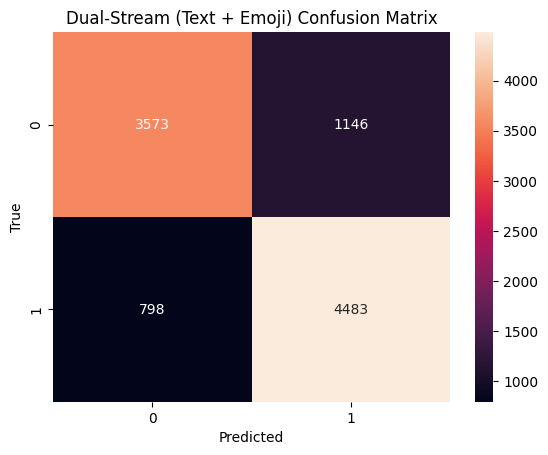

In [81]:
def evaluate_model(model, loader, device, title="Model"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emoji_embeds = batch['emoji_embeds'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, emoji_embeds)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(f"\nClassification Report for {title}:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(model, test_loader, device, title="Dual-Stream (Text + Emoji)")


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Text-Only model saved to textonly_sentiment_model.pth


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.71it/s]



Classification Report for Text-Only:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      4719
           1       0.80      0.84      0.82      5281

    accuracy                           0.81     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.81      0.81     10000



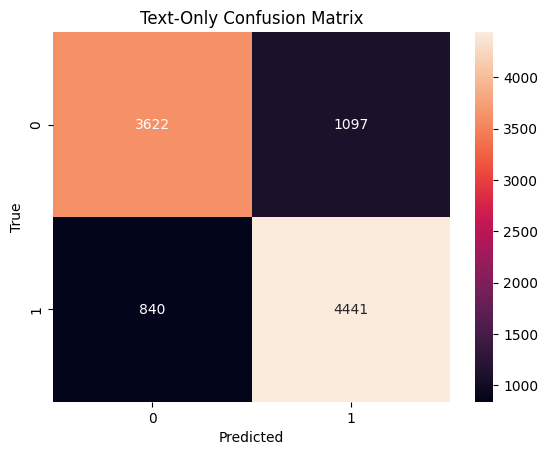

In [82]:
text_model = TextOnlyModel(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(text_model.parameters(), lr=2e-5)

epochs = 3
for epoch in range(epochs):
    text_model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        emoji_embeds = batch['emoji_embeds'].to(device)
        labels = batch['label'].to(device)

        outputs = text_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Text-Only Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=loss.item())

# Text-Only model saving
textonly_model_path = "textonly_sentiment_model.pth"
torch.save(text_model.state_dict(), textonly_model_path)
print(f"Text-Only model saved to {textonly_model_path}")

evaluate_model(text_model, test_loader, device, title="Text-Only")

